# Gradient Boosting Queue Forecasting

## 1. Business Understanding

People's Own Savings Bank (POSB) in Zimbabwe faces growing customer volumes and variable staffing, leading to long wait times. The objective is to deliver a predictive system capable of estimating queue waiting times for incoming customers. Accurate, fast predictions enable smarter teller allocation, proactive communication, and improved customer satisfaction across Agenda 2063, NDS1, and NDS2 objectives.


In [1]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
pd.set_option("display.max_columns", 50)

DATA_PATH = Path("queue_data1.csv")
assert DATA_PATH.exists(), "queue_data.csv not found."

SEED = 42

from sklearn.ensemble import GradientBoostingRegressor

## 2. Data Understanding

Load the augmented POSB queue dataset and inspect schema + headline stats before any cleaning.

In [2]:
df_raw = pd.read_csv(DATA_PATH)
print(f"Loaded dataset with {len(df_raw):,} rows and {df_raw.shape[1]} columns.")
df_raw.head()

Loaded dataset with 4,500 rows and 5 columns.


,arrival_time,start_time,finish_time,wait_time,queue_length
0,01-05-2023 20.34,01-05-2023 20.58,2023-05-01 21:22:26,23.55,24.0
1,13-10-2023 17.47,13-10-2023 18.02,2023-10-13 18:07:08,14.86,9.0
2,23-09-2023 19.17,23-09-2023 19.35,2023-09-23 19:37:48,17.95,24.0
3,29-10-2023 23.04,29-10-2023 23.42,29-10-2023 23:53:07.045146,38.24,64.0
4,30-03-2023 19.51,30-03-2023 19.51,2023-03-30 20:00:39.400000000,9.49,12.0


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   arrival_time  4421 non-null   object 
 1   start_time    4499 non-null   object 
 2   finish_time   4500 non-null   object 
 3   wait_time     4397 non-null   float64
 4   queue_length  4400 non-null   float64
dtypes: float64(2), object(3)
memory usage: 175.9+ KB


In [4]:
numeric_profile = (
    df_raw.assign(
        wait_time=pd.to_numeric(df_raw["wait_time"], errors="coerce"),
        queue_length=pd.to_numeric(df_raw["queue_length"], errors="coerce"),
    )[["wait_time", "queue_length"]]
)
numeric_profile.describe()

,wait_time,queue_length
count,4397.000000,4400.000000
mean,21.821344,34.791591
std,11.551890,23.600389
min,-2.930000,0.000000
25%,16.100000,24.000000
50%,21.300000,32.000000
75%,26.340000,42.000000
max,180.730000,239.000000


In [5]:
df_missing = df_raw.replace("", np.nan)
missing_summary = (
    df_missing.isna()
    .sum()
    .to_frame("missing_count")
    .assign(missing_pct=lambda d: 100 * d["missing_count"] / len(df_missing))
    .sort_values("missing_pct", ascending=False)
)
missing_summary

,missing_count,missing_pct
wait_time,103,2.288889
queue_length,100,2.222222
arrival_time,79,1.755556
start_time,1,0.022222
finish_time,0,0.000000


### Exploratory visuals

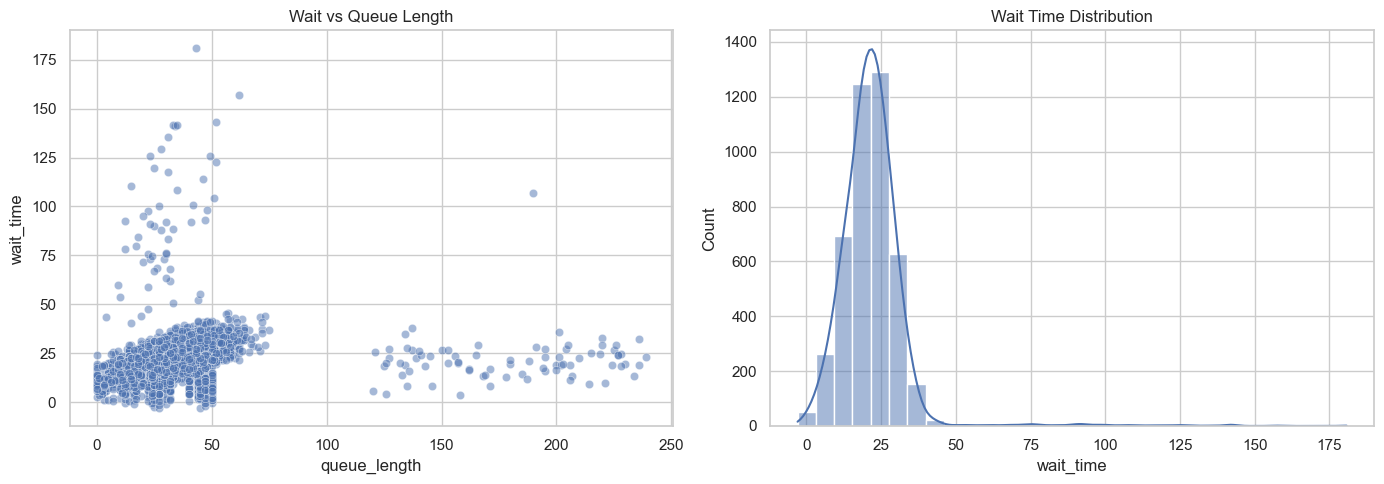

In [6]:
df_plot = df_raw.copy()
df_plot["wait_time"] = pd.to_numeric(df_plot["wait_time"], errors="coerce")
df_plot["queue_length"] = pd.to_numeric(df_plot["queue_length"], errors="coerce")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(data=df_plot, x="queue_length", y="wait_time", ax=axes[0], alpha=0.5)
axes[0].set_title("Wait vs Queue Length")

sns.histplot(df_plot["wait_time"], bins=30, kde=True, ax=axes[1])
axes[1].set_title("Wait Time Distribution")
plt.tight_layout()

## 3. Data Preparation

In [7]:
from datetime import datetime
from dateutil import parser

KNOWN_FORMATS = [
    "%d-%m-%Y %H.%M",
    "%d-%m-%Y %H:%M",
    "%Y-%m-%d %H:%M:%S.%f",
    "%Y-%m-%d %H:%M:%S",
    "%Y-%m-%d %H:%M",
    "%Y/%m/%d %H:%M:%S",
]


def parse_datetime(value):
    """Parse strings or epoch-based timestamps into pandas datetimes."""
    if pd.isna(value) or value == "":
        return pd.NaT

    def try_epoch(v):
        try:
            numeric_value = float(v)
        except (TypeError, ValueError):
            return None
        if np.isnan(numeric_value):
            return None
        abs_value = abs(numeric_value)
        unit = None
        if 1e9 <= abs_value < 1e12:
            unit = "s"
        elif 1e12 <= abs_value < 1e15:
            unit = "ms"
        if unit is None:
            return None
        try:
            return pd.to_datetime(numeric_value, unit=unit)
        except (ValueError, OverflowError):
            return None

    epoch_dt = try_epoch(value)
    if epoch_dt is not None:
        return epoch_dt

    text = str(value)
    for fmt in KNOWN_FORMATS:
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            continue
    try:
        return parser.parse(text, dayfirst=True)
    except (ValueError, TypeError):
        return pd.NaT


df_clean = df_raw.replace("", np.nan).drop_duplicates().copy()
df_clean["arrival_time"] = df_clean["arrival_time"].apply(parse_datetime)
df_clean["start_time"] = df_clean["start_time"].apply(parse_datetime)
df_clean["finish_time"] = df_clean["finish_time"].apply(parse_datetime)

df_clean = df_clean.dropna(subset=["arrival_time", "start_time", "finish_time"])

df_clean["wait_time_minutes"] = pd.to_numeric(df_clean["wait_time"], errors="coerce")
df_clean["queue_length_numeric"] = pd.to_numeric(df_clean["queue_length"], errors="coerce")

df_clean["computed_wait"] = (df_clean["start_time"] - df_clean["arrival_time"]).dt.total_seconds() / 60
df_clean["computed_service"] = (df_clean["finish_time"] - df_clean["start_time"]).dt.total_seconds() / 60

df_clean.loc[df_clean["wait_time_minutes"].isna(), "wait_time_minutes"] = df_clean.loc[
    df_clean["wait_time_minutes"].isna(), "computed_wait"
]
df_clean["wait_time_minutes"] = df_clean["wait_time_minutes"].fillna(df_clean["wait_time_minutes"].median()).clip(lower=0)
df_clean["queue_length_numeric"] = df_clean["queue_length_numeric"].fillna(df_clean["queue_length_numeric"].median())
df_clean["computed_service"] = df_clean["computed_service"].fillna(df_clean["computed_service"].median()).clip(lower=1)

df_clean.head()


,arrival_time,start_time,finish_time,wait_time,queue_length,wait_time_minutes,queue_length_numeric,computed_wait,computed_service
0,2023-05-01 20:34:00,2023-05-01 20:58:00,2023-05-01 21:22:26.000000,23.55,24.0,23.55,24.0,24.0,24.433333
1,2023-10-13 17:47:00,2023-10-13 18:02:00,2023-10-13 18:07:08.000000,14.86,9.0,14.86,9.0,15.0,5.133333
2,2023-09-23 19:17:00,2023-09-23 19:35:00,2023-09-23 19:37:48.000000,17.95,24.0,17.95,24.0,18.0,2.800000
3,2023-10-29 23:04:00,2023-10-29 23:42:00,2023-10-29 23:53:07.045146,38.24,64.0,38.24,64.0,38.0,11.117419
4,2023-03-30 19:51:00,2023-03-30 19:51:00,2023-03-30 20:00:39.400000,9.49,12.0,9.49,12.0,0.0,9.656667


In [8]:
def remove_outliers(series, multiplier=1.5):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - multiplier * iqr
    upper = q3 + multiplier * iqr
    mask = series.between(lower, upper)
    return mask, lower, upper

wait_mask, wait_lower, wait_upper = remove_outliers(df_clean["wait_time_minutes"], 1.5)
queue_mask, queue_lower, queue_upper = remove_outliers(df_clean["queue_length_numeric"], 1.5)

df_model = df_clean[wait_mask & queue_mask].copy()
df_model["arrival_hour"] = df_model["arrival_time"].dt.hour
df_model["arrival_minute"] = df_model["arrival_time"].dt.minute
df_model["arrival_dayofweek"] = df_model["arrival_time"].dt.dayofweek
df_model["day_of_week"] = df_model["arrival_time"].dt.day_name()
df_model["month"] = df_model["arrival_time"].dt.month_name().str[:3]
df_model["is_weekend"] = df_model["arrival_dayofweek"].isin([5, 6]).astype(int)

df_model["hour_sin"] = np.sin(2 * np.pi * df_model["arrival_hour"] / 24)
df_model["hour_cos"] = np.cos(2 * np.pi * df_model["arrival_hour"] / 24)
df_model["traffic_intensity"] = df_model["queue_length_numeric"] * df_model["computed_service"]

arrival_floor_5min = df_model["arrival_time"].dt.floor("5min")
df_model["arrivals_per_5min"] = arrival_floor_5min.groupby(arrival_floor_5min).transform("count")
df_model["arrival_gap_seconds"] = df_model["arrival_time"].diff().dt.total_seconds().fillna(0)
df_model["minutes_since_open"] = (
    df_model["arrival_time"] - df_model["arrival_time"].dt.normalize()
).dt.total_seconds() / 60
df_model["cumulative_customers"] = np.arange(1, len(df_model) + 1)

df_model = df_model.sort_values("arrival_time").reset_index(drop=True)
clip_lower, clip_upper = df_model["wait_time_minutes"].quantile([0.01, 0.99])
df_model["wait_time_denoised"] = df_model["wait_time_minutes"].clip(clip_lower, clip_upper)

# Short-term lags and rollups to capture queue dynamics
df_model["lag_wait_1"] = df_model["wait_time_denoised"].shift(1)
df_model["lag_wait_3"] = df_model["wait_time_denoised"].shift(3)
df_model["lag_queue_1"] = df_model["queue_length_numeric"].shift(1)
df_model["lag_service_1"] = df_model["computed_service"].shift(1)

rolling_window = 5
df_model["rolling_wait_mean_5"] = df_model["wait_time_denoised"].rolling(rolling_window, min_periods=1).mean()
df_model["rolling_wait_median_5"] = df_model["wait_time_denoised"].rolling(rolling_window, min_periods=1).median()
df_model["rolling_queue_mean_5"] = df_model["queue_length_numeric"].rolling(rolling_window, min_periods=1).mean()
df_model["rolling_service_mean_5"] = df_model["computed_service"].rolling(rolling_window, min_periods=1).mean()
df_model["rolling_arrival_gap_mean_5"] = df_model["arrival_gap_seconds"].rolling(rolling_window, min_periods=1).mean()

# Trend-sensitive features
df_model["ema_wait_10"] = df_model["wait_time_denoised"].ewm(span=10, adjust=False).mean()
df_model["ema_queue_10"] = df_model["queue_length_numeric"].ewm(span=10, adjust=False).mean()
df_model["service_load_ratio"] = df_model["queue_length_numeric"] / np.clip(df_model["computed_service"], 1, None)
df_model["cumulative_in_system"] = df_model["queue_length_numeric"].cumsum()

lag_fillers = {
    "lag_wait_1": df_model["wait_time_denoised"].median(),
    "lag_wait_3": df_model["wait_time_denoised"].median(),
    "lag_queue_1": df_model["queue_length_numeric"].median(),
    "lag_service_1": df_model["computed_service"].median(),
}
df_model = df_model.fillna(lag_fillers)

print(
    f"Clipped wait times to [{clip_lower:.2f}, {clip_upper:.2f}] minutes (affects {(df_model['wait_time_minutes'] != df_model['wait_time_denoised']).sum()} rows)"
)
df_model.head()


Clipped wait times to [3.44, 37.01] minutes (affects 86 rows)


,arrival_time,start_time,finish_time,wait_time,queue_length,wait_time_minutes,queue_length_numeric,computed_wait,computed_service,arrival_hour,arrival_minute,arrival_dayofweek,day_of_week,month,is_weekend,hour_sin,hour_cos,traffic_intensity,arrivals_per_5min,arrival_gap_seconds,minutes_since_open,cumulative_customers,wait_time_denoised,lag_wait_1,lag_wait_3,lag_queue_1,lag_service_1,rolling_wait_mean_5,rolling_wait_median_5,rolling_queue_mean_5,rolling_service_mean_5,rolling_arrival_gap_mean_5,ema_wait_10,ema_queue_10,service_load_ratio,cumulative_in_system
0,2023-03-30 00:10:00,2023-03-30 00:16:00,2023-03-30 00:33:38.200000,17.57,28.0,17.57,28.0,6.0,17.636667,0,10,3,Thursday,Mar,0,0.0,1.0,493.826667,25,-14627280.0,10.0,4023,17.57,21.095,21.095,32.0,10.966667,17.570000,17.570,28.0,17.636667,-14627280.0,17.570000,28.0,1.587602,28.0
1,2023-03-30 00:10:00,2023-03-30 00:19:00,2023-03-30 00:30:52.600000,11.81,28.0,11.81,28.0,9.0,11.876667,0,10,3,Thursday,Mar,0,0.0,1.0,332.546667,25,-18699480.0,10.0,61,11.81,17.570,21.095,28.0,17.636667,14.690000,14.690,28.0,14.756667,-16663380.0,16.522727,28.0,2.357564,56.0
2,2023-03-30 00:10:00,2023-03-30 00:11:00,2023-03-30 00:24:20.199999,13.27,28.0,13.27,28.0,1.0,13.336667,0,10,3,Thursday,Mar,0,0.0,1.0,373.426666,25,-27588420.0,10.0,2611,13.27,11.810,21.095,28.0,11.876667,14.216667,13.270,28.0,14.283333,-20305060.0,15.931322,28.0,2.099475,84.0
3,2023-03-30 00:10:00,2023-03-30 00:13:00,2023-03-30 00:25:48.400000,12.74,28.0,12.74,28.0,3.0,12.806667,0,10,3,Thursday,Mar,0,0.0,1.0,358.586667,25,-17508720.0,10.0,283,12.74,13.270,17.570,28.0,13.336667,13.847500,13.005,28.0,13.914167,-19605975.0,15.351082,28.0,2.186361,112.0
4,2023-03-30 00:10:00,2023-03-30 00:17:00,2023-03-30 00:29:49.600000,12.76,28.0,12.76,28.0,7.0,12.826667,0,10,3,Thursday,Mar,0,0.0,1.0,359.146667,25,-15139800.0,10.0,1850,12.76,12.740,11.810,28.0,12.806667,13.630000,12.760,28.0,13.696667,-18712740.0,14.879976,28.0,2.182952,140.0



### Additional Exploratory Visualizations
To better understand the engineered signals, the following charts highlight temporal patterns, arrival intensity, and relationships across the enriched feature set.


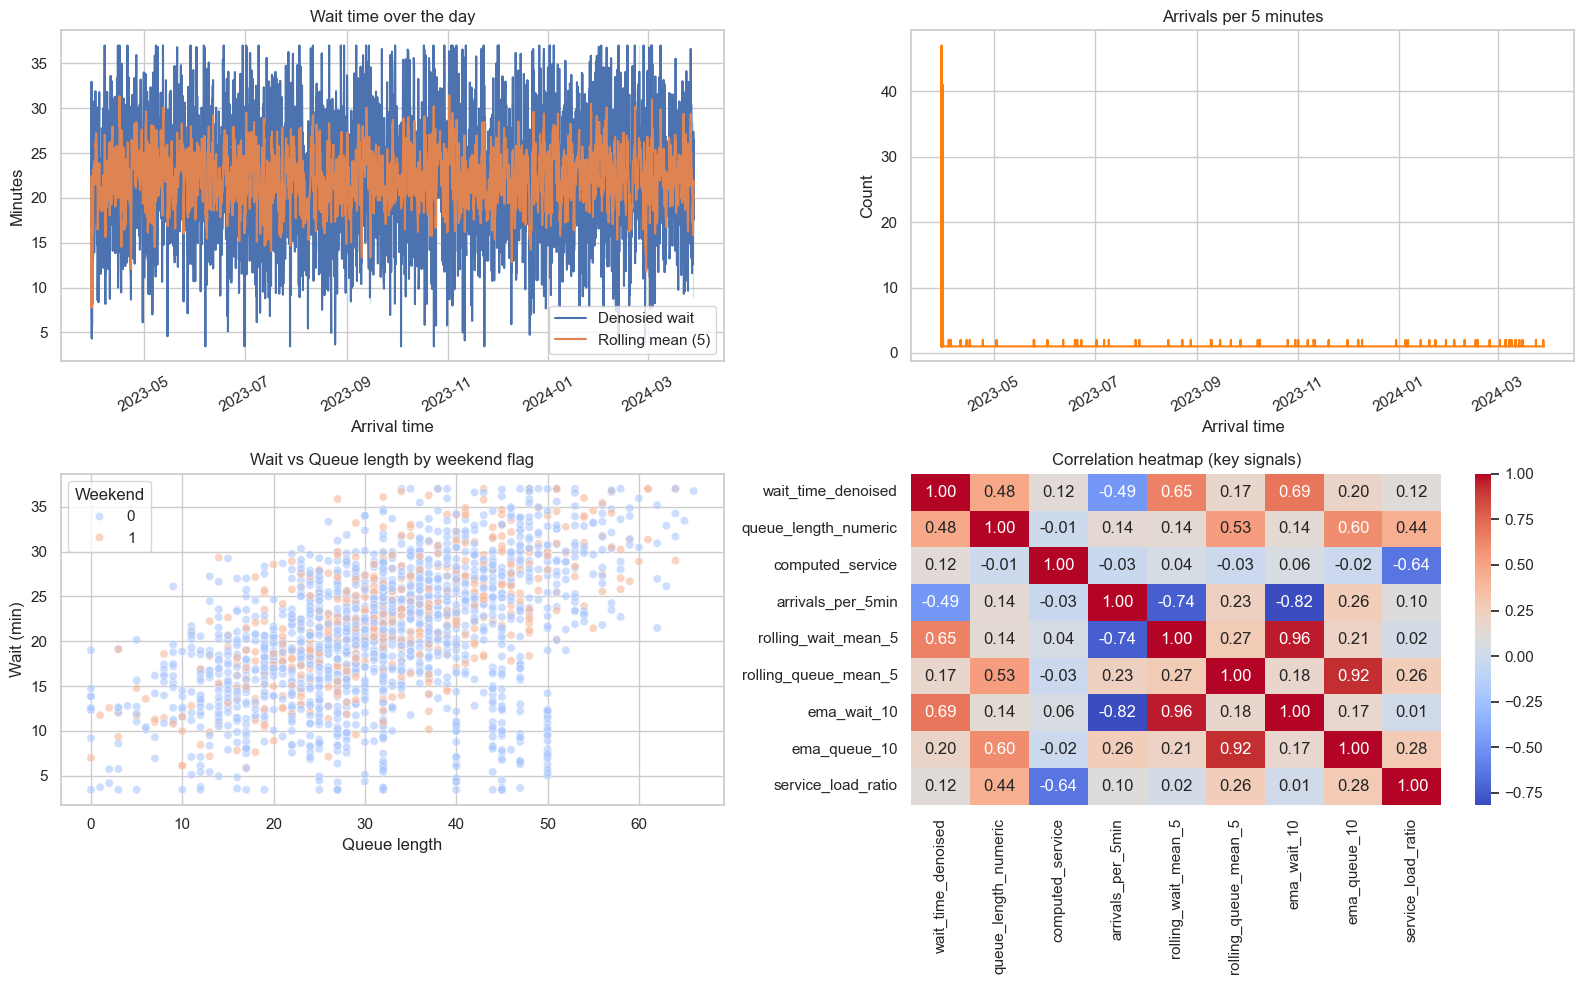

In [9]:

viz_df = df_model.copy()
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.lineplot(data=viz_df, x='arrival_time', y='wait_time_denoised', ax=axes[0, 0], label='Denosied wait')
sns.lineplot(data=viz_df, x='arrival_time', y='rolling_wait_mean_5', ax=axes[0, 0], label='Rolling mean (5)')
axes[0, 0].set_title('Wait time over the day')
axes[0, 0].set_xlabel('Arrival time')
axes[0, 0].set_ylabel('Minutes')
axes[0, 0].tick_params(axis='x', rotation=30)

sns.lineplot(data=viz_df, x='arrival_time', y='arrivals_per_5min', ax=axes[0, 1], color='#ff7f0e')
axes[0, 1].set_title('Arrivals per 5 minutes')
axes[0, 1].set_xlabel('Arrival time')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=30)

sns.scatterplot(data=viz_df.sample(min(2000, len(viz_df))), x='queue_length_numeric', y='wait_time_denoised', hue='is_weekend', palette='coolwarm', ax=axes[1, 0], alpha=0.6)
axes[1, 0].set_title('Wait vs Queue length by weekend flag')
axes[1, 0].set_xlabel('Queue length')
axes[1, 0].set_ylabel('Wait (min)')
axes[1, 0].legend(title='Weekend', loc='upper left')

corr_cols = [
    'wait_time_denoised',
    'queue_length_numeric',
    'computed_service',
    'arrivals_per_5min',
    'rolling_wait_mean_5',
    'rolling_queue_mean_5',
    'ema_wait_10',
    'ema_queue_10',
    'service_load_ratio',
]
corr = viz_df[corr_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Correlation heatmap (key signals)')

plt.tight_layout()


In [10]:
modelling_columns = [
    "queue_length_numeric",
    "computed_service",
    "arrival_hour",
    "arrival_minute",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "traffic_intensity",
    "arrivals_per_5min",
    "arrival_gap_seconds",
    "minutes_since_open",
    "cumulative_customers",
    "rolling_wait_mean_5",
    "rolling_wait_median_5",
    "rolling_queue_mean_5",
    "rolling_service_mean_5",
    "rolling_arrival_gap_mean_5",
    "ema_wait_10",
    "ema_queue_10",
    "service_load_ratio",
    "cumulative_in_system",
    "lag_wait_1",
    "lag_wait_3",
    "lag_queue_1",
    "lag_service_1",
    "day_of_week",
    "month",
]

X = df_model[modelling_columns]
y = df_model["wait_time_denoised"]

split_idx = int(len(df_model) * 0.75)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

ts_train = df_model["arrival_time"].iloc[:split_idx]
ts_test = df_model["arrival_time"].iloc[split_idx:]

print(
    "Chronological split => train %d (%s to %s), test %d (%s to %s)"
    % (len(X_train), ts_train.min().date(), ts_train.max().date(), len(X_test), ts_test.min().date(), ts_test.max().date())
)


Chronological split => train 3187 (2023-03-30 to 2023-12-16), test 1063 (2023-12-16 to 2024-03-28)


In [11]:
numeric_features = [
    "queue_length_numeric",
    "computed_service",
    "arrival_hour",
    "arrival_minute",
    "is_weekend",
    "hour_sin",
    "hour_cos",
    "traffic_intensity",
    "arrivals_per_5min",
    "arrival_gap_seconds",
    "minutes_since_open",
    "cumulative_customers",
    "rolling_wait_mean_5",
    "rolling_wait_median_5",
    "rolling_queue_mean_5",
    "rolling_service_mean_5",
    "rolling_arrival_gap_mean_5",
    "ema_wait_10",
    "ema_queue_10",
    "service_load_ratio",
    "cumulative_in_system",
    "lag_wait_1",
    "lag_wait_3",
    "lag_queue_1",
    "lag_service_1",
]
categorical_features = ["day_of_week", "month"]

numeric_pipeline = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

encoder_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames:
    encoder_kwargs["sparse_output"] = False
else:
    encoder_kwargs["sparse"] = False

categorical_pipeline = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(**encoder_kwargs))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("cat", categorical_pipeline, categorical_features),
    ]
)

def safe_mape(y_true, y_pred, eps=1e-3):
    denom = np.clip(np.abs(y_true), eps, None)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = safe_mape(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R2": r2}

baseline_models = {
    "Baseline (Mean)": DummyRegressor(strategy="mean"),
    "Baseline (Median)": DummyRegressor(strategy="median"),
}

baseline_results = []
for name, estimator in baseline_models.items():
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", estimator)])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    baseline_results.append({"Model": name, **regression_metrics(y_test, preds)})

pd.DataFrame(baseline_results).set_index("Model")


,MAE,RMSE,MAPE,R2
Model,,,,
Baseline (Mean),5.462689,6.833759,27.074290,-0.108113
Baseline (Median),5.393929,6.741261,27.159053,-0.078319


## 4. Modeling

In [12]:
tscv = TimeSeriesSplit(n_splits=5)

gb_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", GradientBoostingRegressor(random_state=SEED))]
)

param_grid = {
    "model__n_estimators": [200, 300],
    "model__learning_rate": [0.05, 0.075, 0.1],
    "model__max_depth": [2, 3],
    "model__min_samples_leaf": [10, 25, 40],
    "model__subsample": [0.6, 0.8],
    "model__max_features": [None, 0.7],
}

gb_search = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)
gb_search.fit(X_train, y_train)
print("Best GB params:", gb_search.best_params_)

best_model = gb_search.best_estimator_
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

metrics = {
    "Train": regression_metrics(y_train, train_pred),
    "Test": regression_metrics(y_test, test_pred),
}
pd.DataFrame(metrics).T


Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best GB params: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__max_features': 0.7, 'model__min_samples_leaf': 10, 'model__n_estimators': 300, 'model__subsample': 0.8}


,MAE,RMSE,MAPE,R2
Train,2.287948,2.980846,13.321692,0.844075
Test,3.169730,3.990719,16.688505,0.622108


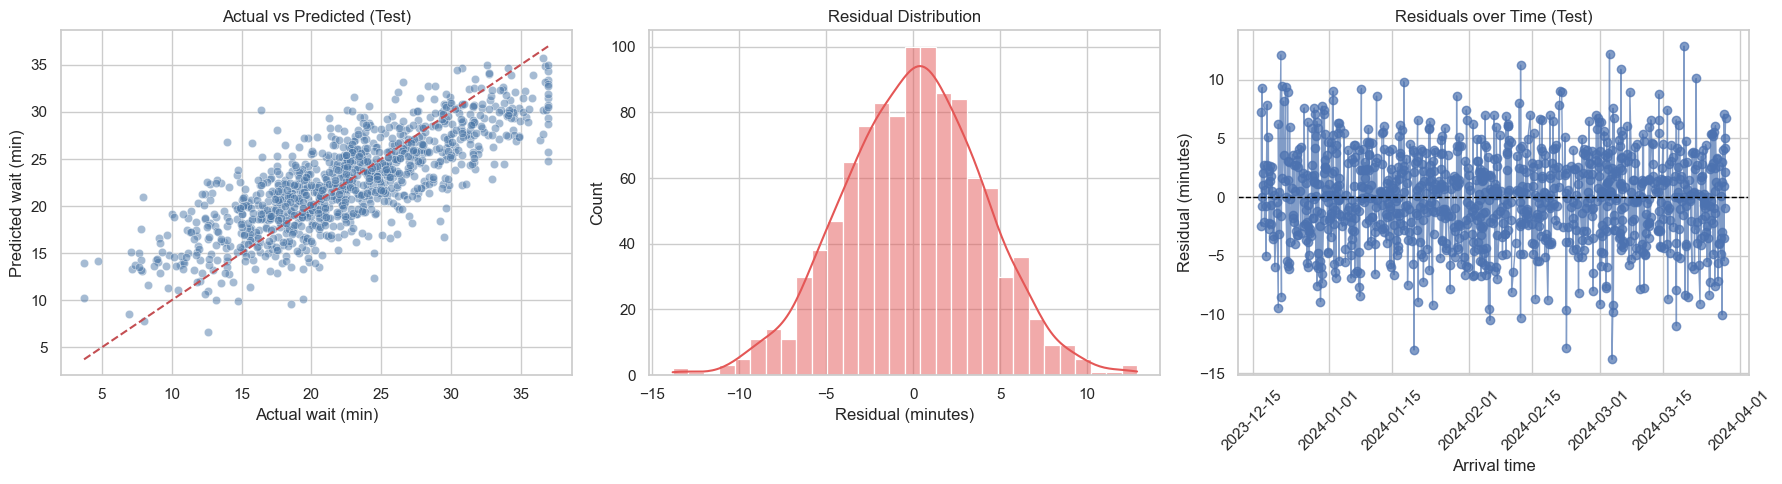

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.scatterplot(x=y_test, y=test_pred, ax=axes[0], alpha=0.5, color="#4C78A8")
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
axes[0].set_title("Actual vs Predicted (Test)")
axes[0].set_xlabel("Actual wait (min)")
axes[0].set_ylabel("Predicted wait (min)")

residuals = y_test - test_pred
sns.histplot(residuals, bins=30, kde=True, ax=axes[1], color="#E45756")
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residual (minutes)")

axes[2].plot(ts_test, residuals, marker="o", linewidth=1, alpha=0.7)
axes[2].axhline(0, color="black", linestyle="--", linewidth=1)
axes[2].set_title("Residuals over Time (Test)")
axes[2].set_xlabel("Arrival time")
axes[2].set_ylabel("Residual (minutes)")
for label in axes[2].get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()



### Model Evaluation
Summarize the tuned Gradient Boosting model on both the chronological hold-out block and the training span to quickly gauge generalization gaps.


In [14]:

metric_table = pd.DataFrame(metrics).T
metric_table.index.name = 'Split'
metric_table = metric_table[['MAE', 'RMSE', 'MAPE', 'R2']]
display(metric_table.style.format({'MAE': '{:.2f}', 'RMSE': '{:.2f}', 'MAPE': '{:.1f}', 'R2': '{:.3f}'}).set_caption('Hold-out vs Train performance'))

residual_df = pd.DataFrame({
    'arrival_time': ts_test.values,
    'actual': y_test.values,
    'predicted': test_pred,
})
residual_df['residual'] = residual_df['actual'] - residual_df['predicted']
error_summary = residual_df['residual'].describe(percentiles=[0.1, 0.5, 0.9]).rename('Residual distribution (minutes)')
display(error_summary.to_frame())


,MAE,RMSE,MAPE,R2
Split,,,,
Train,2.29,2.98,13.3,0.844
Test,3.17,3.99,16.7,0.622


,Residual distribution (minutes)
count,1063.000000
mean,-0.003810
std,3.992596
min,-13.827653
10%,-5.070000
50%,0.105153
90%,5.029882
max,12.875392



### Feature Importance
Identify the most influential engineered drivers behind the Gradient Boosting predictions.


,Feature,Importance
17,ema_wait_10,0.471154
0,queue_length_numeric,0.185596
12,rolling_wait_mean_5,0.068205
8,arrivals_per_5min,0.060410
1,computed_service,0.043621
21,lag_wait_1,0.033457
7,traffic_intensity,0.032860
22,lag_wait_3,0.022780
18,ema_queue_10,0.018618
13,rolling_wait_median_5,0.012652


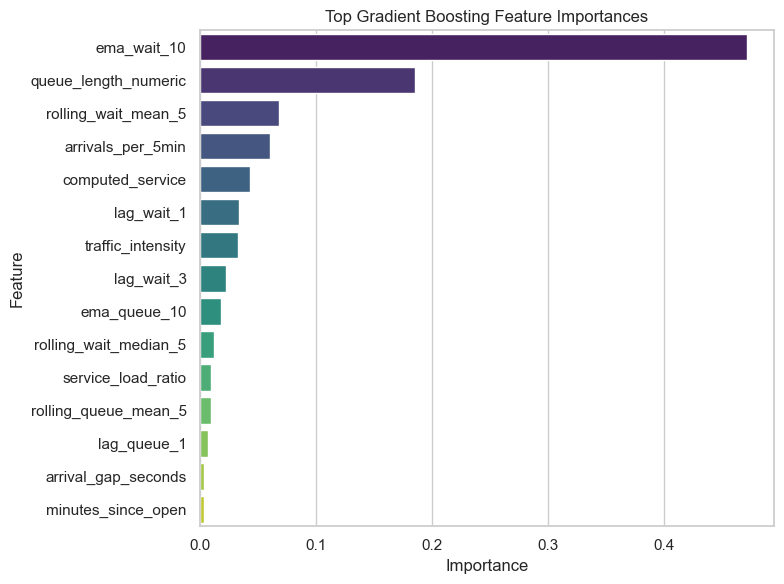

In [15]:

def get_feature_names(preprocessor):
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            encoder = transformer.named_steps['encoder']
            feature_names.extend(encoder.get_feature_names_out(cols))
    return feature_names

feature_names = get_feature_names(best_model.named_steps['preprocessor'])
importances = best_model.named_steps['model'].feature_importances_
importance_df = (
    pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    .sort_values('Importance', ascending=False)
    .head(15)
)
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis', ax=ax)
ax.set_title('Top Gradient Boosting Feature Importances')
plt.tight_layout()
importance_df


In [16]:
tscv = TimeSeriesSplit(n_splits=5)
cv_results = pd.DataFrame(
    cross_validate(
        best_model,
        X,
        y,
        cv=tscv,
        scoring=("neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"),
        n_jobs=-1,
    )
)
cv_results = cv_results.rename(
    columns={
        "test_neg_mean_absolute_error": "MAE",
        "test_neg_root_mean_squared_error": "RMSE",
        "test_r2": "R2",
    }
)
cv_results["MAE"] = -cv_results["MAE"]
cv_results["RMSE"] = -cv_results["RMSE"]
cv_results.describe()[["MAE", "RMSE", "R2"]]

,MAE,RMSE,R2
count,5.000000,5.000000,5.000000
mean,3.323478,4.151288,0.580281
std,0.184750,0.230271,0.067881
min,3.123105,3.923412,0.472349
25%,3.188722,3.968350,0.560203
50%,3.299070,4.105513,0.602464
75%,3.422652,4.278660,0.621215
max,3.583843,4.480508,0.645176
